# Laboratorio 5.1: Redes Recurrentes

**Objetivo:** Clasificar de apellidos, según su nacionalidad, utilizando un modelo simple de redes neuronales recurrentes. (A nivel de caracter) 

**Descripción:**

Construiremos y entrenaremos un RNN de nivel básico para clasificar palabras. Este tutorial, junto con los dos siguientes, muestra cómo hacer el preprocesamiento de datos para el modelado de un proceso de lenguaje natural (NPL) "desde cero". Se utilizarán algunas de las funciones  de *torchtext*, de modo que se pueda ver cómo el preprocesamiento para el modelado de NPL funciona a bajo nivel.

Una RNN a nivel de carácter lee las palabras como una serie de caracteres - produciendo una predicción y un "estado oculto" en cada paso, alimentando su estado oculto anterior en cada paso siguiente. Tomamos la predicción final como salida, es decir, a qué clase pertenece la palabra.

Específicamente, entrenaremos en unos pocos miles de apellidos de 18 idiomas de origen, y predeciremos de qué idioma proviene un nombre basándonos en la ortografía.



---
NLP From Scratch: Classifying Names with a Character-Level RNN

**Autor:** Sean Robertson <https://github.com/spro/practical-pytorch>_


In [ ]:
%matplotlib inline

**Cargar los datos de Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Preparando los datos
Bajar la base de datos de apellidos `aquí <https://download.pytorch.org/tutorial/data.zip>`.

Extraer estos en el directorio actual.

En ``data/names`` se encuentran 18 textos en archivos llamados "[lenguaje].txt". Cada archivo contiene apellidos, uno por línea, la mayoría normalizados (pero deben ser convertidos de Unicode a ASCII).

Terminaremos con un diccionario con listas de nombres por idioma,
``Idioma: [nombres ...]}``. Las variables genéricas "categoría" y "línea"
(para el lenguaje y el nombre en nuestro caso) se utilizan para su posterior ampliación.

In [1]:
import unicodedata
import string
import glob
import os

PATH_TEXT = 'names'

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
#print(n_letters)

# Convertir el código Unicode al texto ASCII (https://stackoverflow.com/a/518232/2809427)
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

#print(unicodeToAscii('Ślusàrski'))

# Leer los archivos y los cargaremos en un estructura de tipo diccionario
category_lines = {}
all_categories = []

def readLines(filenames):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in glob.glob(f'{PATH_TEXT}/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

Ahora tenemos `category_lines`, un diccionario que mapea cada categoría (idioma) a una lista de líneas (nombres). También llevamos un registro de `all_categories` (sólo una lista de idiomas) y `n_categories` para su posterior referencia.

In [4]:
print(all_categories)

['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']


In [5]:
print(category_lines['Russian'][:5])

['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin']


## 2. Convirtiendo los nombres a tensores

Ahora que tenemos todos los nombres organizados, necesitamos convertirlos en
Tensores para hacer cualquier uso de ellos.

Para representar una sola **letra**, usamos un "***one-hot vector***" de tamaño `<1 x n_letters>`. Un vector de una letra (***one-hot vector***), consiste en un arreglo que contiene ceros y un (uno solo) en el índice de la letra que se quiere representar. Por ejemplo, `"b"= <0 1 0 0 0 ...>`.

Para representar una **palabra** unimos varios vectores de una letra en una matriz 2D `<line_length x 1 x n_letters>`.

La dimesión 1 extra indica a Pytorch que esa estructura está en lotes (*batch*), indicando que el tamaño del lote es uno.


In [6]:
import torch

# Encontrar el indice de una letra en all_letters
def letterToIndex(letter):
  return all_letters.find(letter)

# Construir un vector one-hot letter (Ilustrativo)
def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1

  return tensor

print(lineToTensor('Juan'))



tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

## 3. Creando la red

Antes del *autograd*, la creación de una red neural recurrente en Torch implicaba
clonar los parámetros de una capa en varios pasos de tiempo. Las capas
mantenían estados y gradientes ocultos que ahora son manejados enteramente por la librería. Esto significa que puedes implementar un RNN de una manera muy "pura", como capas regulares de alimentación...

Este módulo RNN (en su mayoría copiado de "The PyTorch for Torch users")
tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
son sólo 2 capas lineales que operan en un estado de entrada y oculto, con
una capa de LogSoftmax después de la salida.

Figura:: https://i.imgur.com/Z2xbySO.png

Figura [(softmax)](https://cdn-images-1.medium.com/freeze/max/1000/1*ghDbeGZZUloPOJK7g3OyBg.png?q=20)::



In [7]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1) # vector [1 x (input + hidden)]
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

Para ejecutar un paso de esta red necesitamos pasar una entrada (en nuestro caso, el
Tensor para la letra actual) y un estado oculto anterior (que nosotros
inicializar como ceros al principio). Recuperaremos la salida (probabilidad de
cada idioma) y un siguiente estado oculto (que guardamos para el próximo
paso).

In [8]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

print(output)
print(next_hidden)

tensor([[-2.8598, -2.9765, -2.8569, -2.8930, -2.8835, -2.8636, -2.8614, -2.9085,
         -2.9627, -2.8796, -2.8224, -2.8944, -2.9013, -2.8807, -2.8275, -2.8392,
         -2.9634, -2.9723]], grad_fn=<LogSoftmaxBackward0>)
tensor([[ 0.0016, -0.0925,  0.0850,  0.0684, -0.0535,  0.0065,  0.0229,  0.0496,
          0.0153, -0.0636,  0.0064, -0.1275, -0.0658,  0.0149, -0.0171, -0.0012,
          0.0555,  0.1338, -0.0742,  0.0116, -0.0087,  0.0223, -0.0538, -0.1362,
          0.1394, -0.0955,  0.0962,  0.0063, -0.1123,  0.1113, -0.1015,  0.0047,
          0.0148,  0.0280,  0.0309, -0.1105, -0.0002,  0.0153, -0.0054, -0.1109,
          0.1023, -0.0611, -0.0973,  0.1111,  0.0038,  0.0449,  0.0369, -0.0622,
          0.0302,  0.0038, -0.1229, -0.0107,  0.1334, -0.0587, -0.0313, -0.0702,
          0.0426,  0.0303, -0.0418,  0.0828, -0.1175, -0.0284,  0.0251, -0.0654,
         -0.0325,  0.0121,  0.0652,  0.0027,  0.0736,  0.0265,  0.0170, -0.0142,
          0.0852,  0.0729,  0.0528, -0.0541,  0.0

Para mejorar la eficiencia no queremos crear un nuevo Tensor para
cada paso, así que usaremos ``lineToTensor`` en lugar de
``letterToTensor`` y usa *slices*. Esto podría ser optimizado aún más por
precomputando lotes de Tensores.

In [9]:
input = lineToTensor('Alberto')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(next_hidden)

tensor([[-2.8598, -2.9765, -2.8569, -2.8930, -2.8835, -2.8636, -2.8614, -2.9085,
         -2.9627, -2.8796, -2.8224, -2.8944, -2.9013, -2.8807, -2.8275, -2.8392,
         -2.9634, -2.9723]], grad_fn=<LogSoftmaxBackward0>)
tensor([[ 0.0016, -0.0925,  0.0850,  0.0684, -0.0535,  0.0065,  0.0229,  0.0496,
          0.0153, -0.0636,  0.0064, -0.1275, -0.0658,  0.0149, -0.0171, -0.0012,
          0.0555,  0.1338, -0.0742,  0.0116, -0.0087,  0.0223, -0.0538, -0.1362,
          0.1394, -0.0955,  0.0962,  0.0063, -0.1123,  0.1113, -0.1015,  0.0047,
          0.0148,  0.0280,  0.0309, -0.1105, -0.0002,  0.0153, -0.0054, -0.1109,
          0.1023, -0.0611, -0.0973,  0.1111,  0.0038,  0.0449,  0.0369, -0.0622,
          0.0302,  0.0038, -0.1229, -0.0107,  0.1334, -0.0587, -0.0313, -0.0702,
          0.0426,  0.0303, -0.0418,  0.0828, -0.1175, -0.0284,  0.0251, -0.0654,
         -0.0325,  0.0121,  0.0652,  0.0027,  0.0736,  0.0265,  0.0170, -0.0142,
          0.0852,  0.0729,  0.0528, -0.0541,  0.0

Como puedes ver, la salida es un tensor ``<1 x n_categories>``, donde
cada *item* es la probabilidad de esa categoría (más alta es más probable).

## 4. Entrenando la red

Preparando los datos
--------------------

Antes de entrar en el entrenamiento debemos hacer algunas funciones de ayuda. La primera es interpretar el resultado de la red, que sabemos que es una probabilidad de cada categoría. Podemos usar Tensor.topk para obtener el índice de mayor valor:

In [10]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 10)


También queremos una forma rápida de obtener un ejemplo de entrenamiento (un nombre y su
idioma):

In [11]:
import random

# Elige un elemento de lista en forma aleatoria
def randomChoice(lista):
  return lista[random.randint(0, len(lista)-1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  # Selecciono la palabra (nombre) de una categoria
  line = randomChoice(category_lines[category])
  # Convertir tensores
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

print(all_categories)
for i in range(20):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('categoria=', category, '/ palabra=', line)

['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
categoria= Dutch / palabra= Veen
categoria= French / palabra= Robert
categoria= Greek / palabra= Karahalios
categoria= Irish / palabra= Callaghan
categoria= Korean / palabra= Hyun 
categoria= Spanish / palabra= Machado
categoria= Polish / palabra= Dubanowski
categoria= Dutch / palabra= Schneider
categoria= Greek / palabra= Karkampasis
categoria= Vietnamese / palabra= Sai
categoria= Spanish / palabra= Ibanez
categoria= Polish / palabra= Klimek
categoria= Polish / palabra= Winograd
categoria= Czech / palabra= Bock
categoria= Spanish / palabra= Rodriquez
categoria= Scottish / palabra= Hay
categoria= Japanese / palabra= Onohara
categoria= Polish / palabra= Kaminski
categoria= Irish / palabra= Brian
categoria= Russian / palabra= Jakhaev


Entrenamiento de la red
--------------------

Ahora todo lo que se necesita para entrenar a esta red es mostrarle un montón de ejemplos.

Para la función de pérdida `n.NLLLoss` es apropiado, ya que la última
La capa del RNN es `nn.LogSoftmax`.

In [12]:
criterion = nn.NLLLoss()

Cada ciclo de entrenamiento hará:

1. Crear tensores de entrada y de destino

2. Crear un estado inicial oculto igual a cero

3. Leer cada letra y mantener el estado oculto para la próxima letra.

4. Comparar el resultado final con el objetivo

5. *Back-propagate*

6. Devolver la salida y la pérdida

In [13]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
  # Inicializar la capa hidden en cero
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  # Actualizar los parametros del modelo
  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()



Ahora sólo tenemos que correr esto con un montón de ejemplos. Como la función del entrenamiento devuelve tanto la salida como la pérdida, podemos imprimir sus predicciones y también llevar la cuenta de la pérdida. Ya que hay miles de ejemplos, imprimimos sólo cada uno de ellos y tomamos un promedio de la pérdida.

In [14]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Guardamos la perdida
current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now -since
  m = math.floor(s/60)
  s -= m *60
  return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
  # Obtener una categoria y una palabra de forma aleatoria
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  # Imprimir los resultados
  if iter % print_every == 0: 
    guess, guess_i = categoryFromOutput(output)
    correct = 'OK' if guess == category else 'ERROR (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter/n_iters * 100, timeSince(start),loss, line, guess, correct))

  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 1s) 2.8726 Smith / Russian ERROR (Scottish)
10000 10% (0m 2s) 2.6531 Malafa / Japanese ERROR (Czech)
15000 15% (0m 4s) 1.0220 Thao / Chinese ERROR (Vietnamese)
20000 20% (0m 5s) 1.7773 Morehin / Irish ERROR (Russian)
25000 25% (0m 6s) 1.2581 Mo / Vietnamese ERROR (Korean)
30000 30% (0m 8s) 1.4026 Blazejovsky / Russian ERROR (Czech)
35000 35% (0m 9s) 2.1018 Kuramoto / Italian ERROR (Japanese)
40000 40% (0m 10s) 3.0259 Saitoh / Arabic ERROR (Japanese)
45000 45% (0m 12s) 1.6870 Belo / Spanish ERROR (Portuguese)
50000 50% (0m 13s) 1.5940 Thomson / Irish ERROR (Scottish)
55000 55% (0m 15s) 3.3671 Fergus / German ERROR (Irish)
60000 60% (0m 16s) 0.4197 Bandoni / Italian OK
65000 65% (0m 17s) 3.2227 Dana / Vietnamese ERROR (Czech)
70000 70% (0m 19s) 1.4627 Labelle / Italian ERROR (French)
75000 75% (0m 20s) 0.8336 Lolos / Greek OK
80000 80% (0m 21s) 1.8184 Wiater / Dutch ERROR (Polish)
85000 85% (0m 23s) 2.3822 Muir / Chinese ERROR (Scottish)
90000 90% (0m 24s) 4.9398 Leeuwenhoek 

## 5. Graficando los resultados

Graficar la pérdida histórica de `all_loses` muestra el aprendizaje de la red.

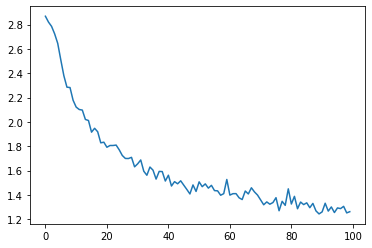

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# 6. Evaluando los resultados

Para ver cómo funciona la red en diferentes categorías, vamos a
crear una **matriz de confusión**, indicando para cada idioma real (filas)
qué idioma adivina la red (columnas). Para calcular la confusión
matriz un montón de muestras se ejecutan a través de la red con
`Evaluar`, que es lo mismo que `Entrenar`, menos el respaldo.

/var/folders/lg/6xllmg393z39__f392znxj000000gn/T/ipykernel_73655/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/lg/6xllmg393z39__f392znxj000000gn/T/ipykernel_73655/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


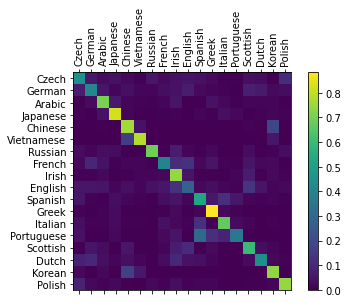

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Puedes elegir los puntos más brillantes en el eje principal que muestren qué
idiomas que adivina incorrectamente, por ejemplo, el chino para el coreano, y el español para el italiano. Parece que le va muy bien con el griego, y muy mal con Inglés (tal vez debido a la superposición con otros idiomas).

In [17]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Bekios')


> Dovesky
(-0.44) Russian
(-1.30) Czech
(-3.31) English

> Jackson
(-0.51) Scottish
(-1.51) English
(-2.71) Russian

> Satoshi
(-0.82) Japanese
(-1.52) Italian
(-2.61) Arabic

> Bekios
(-0.32) Greek
(-2.71) English
(-2.79) Czech


La versión completa del código la pueden revisar en <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`